## Modelling for Fake News Identification

### Feature Selection

**Selected Features**

TF-IDF Vectors, `title`, `exclamation_count`, `question_count`, `capital_ratio`, `polarity`, `subjectivity`, `readability`, `grade_level`

### Pre-processing

In [109]:
# Install Dependencies

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
from textblob import TextBlob
import textstat
from scipy.sparse import hstack

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to C:\Users\streamteck.STREA
[nltk_data]     MTECK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\streamteck.STREAMTEC
[nltk_data]     K\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\streamteck.STREAMT
[nltk_data]     ECK\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\streamteck.STREA
[nltk_data]     MTECK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [36]:
df = pd.read_csv(os.path.join('data', 'news.csv'))

y = df['label']
le = LabelEncoder()
y = le.fit_transform(y)

In [37]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text: str) -> str:
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(clean_text)

In [38]:
tfidf = TfidfVectorizer(
    max_features=10000,
    stop_words='english',
    ngram_range=(1, 2)
)

X_tfidf = tfidf.fit_transform(df['clean_text'])

In [47]:
def extract_linguistic_features(text: str) -> dict:
    features = {}
    features['exclamation_count'] = text.count('!')
    features['question_count'] = text.count('?')
    features['capital_ratio'] = sum(1 for cap in text if cap.isupper()) / (len(text) + 1)
    blob = TextBlob(text)
    features['polarity'] = blob.sentiment.polarity
    features['subjectivity'] = blob.sentiment.subjectivity
    features['readability'] = textstat.flesch_reading_ease(text)
    features['grade_level'] = textstat.flesch_kincaid_grade(text)
    return features

ling_feats = df['text'].apply(extract_linguistic_features)
ling_feats = pd.DataFrame(list(ling_feats))
df = pd.concat([df, ling_feats], axis=1)

In [62]:
meta_feats = df[['exclamation_count', 'question_count', 'capital_ratio', 'polarity', 'subjectivity', 'readability', 'grade_level']]
meta_scaled = StandardScaler().fit_transform(meta_feats)
X_final = hstack([X_tfidf, meta_scaled])

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=37)

print("TF-IDF shape:", X_tfidf.shape)
print("Final shape (with linguistic features):", X_final.shape)

TF-IDF shape: (6335, 10000)
Final shape (with linguistic features): (6335, 10007)


### Training

In [110]:
lr_model = LogisticRegression(
    max_iter=200
)

mnb_model = MultinomialNB(
    alpha=1.0
)

svc_model = SVC(
    kernel='linear',
    C=1.0,
    random_state=37,
    probability=True
)

rfc_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=4,
    min_samples_split=12,
    min_samples_leaf=3,
    n_jobs=-1,
    random_state=37
)

gbc_model = GradientBoostingClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    min_samples_split=12,
    min_samples_leaf=3,
    random_state=37
)

xgbc_model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc',
    random_state=37,
)

model = xgbc_model

In [111]:
model.fit(X_train, y_train)

y_predict = model.predict(X_test)
y_probability = model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_predict))
print("ROC-AUC:", roc_auc_score(y_test, y_probability))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_predict, normalize='true'))

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       629
           1       0.92      0.90      0.91       638

    accuracy                           0.91      1267
   macro avg       0.91      0.91      0.91      1267
weighted avg       0.91      0.91      0.91      1267

ROC-AUC: 0.9685423945058834
Confusion Matrix:
 [[0.91573927 0.08426073]
 [0.10031348 0.89968652]]


In [ ]:
cv_scores = cross_val_score(model, X_final, y, cv=5, scoring='roc_auc')
print("Cross-Validated AUC Scores:\n", cv_scores)
print("Mean CV AUC: ", cv_scores.mean())

### Visualisations

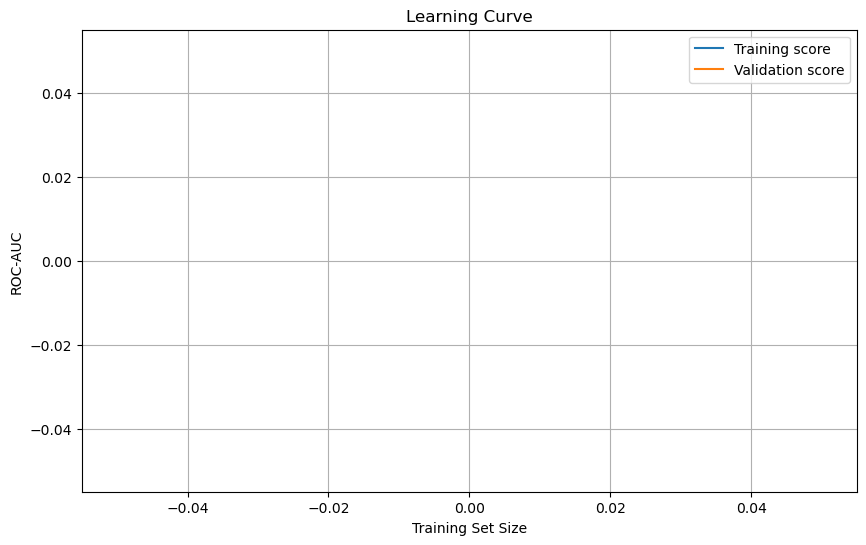

In [112]:
train_sizes, train_scores, val_scores = learning_curve( # type: ignore
    model, X_final, y, cv=5, scoring='roc_auc', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, val_scores_mean, label='Validation score')
plt.xlabel('Training Set Size')
plt.ylabel('ROC-AUC')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()